In [204]:
import csv 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline, KNNWithZScore
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering

%matplotlib inline
movies = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/ratings.csv')
links = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/links.csv')
tags = pd.read_csv('/Users/natashawyatt/Documents/Flatiron_school/Phase_4/Phase_4_Project/ml-latest-small/tags.csv')



In [205]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [206]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [207]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [208]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [209]:
# removing timestamp column from both ratings and tags as it
ratings.drop(columns='timestamp', inplace=True)
tags.drop(columns='timestamp', inplace=True)

In [210]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)


In [211]:
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [212]:
movies['year'].unique()


array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', '2006–2007'], dtype=object)

In [213]:
# 2006-2007...? range shouldnt be in there, after IMDB search it appears to be released in 2007

movies['year'] = movies['year'].replace("2006–2007","2007")


In [214]:
movies[pd.isna(movies['year'])]

,movieId,title,genres,year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [215]:
# These will just be dropped...
movies = movies.dropna(subset=['year'],how='any')


In [216]:
movies['year'].describe()

count     9730
unique     106
top       2002
freq       311
Name: year, dtype: object

In [217]:
movies['year'].value_counts()

2002    311
2006    295
2001    294
2007    285
2000    283
       ... 
1921      1
1908      1
1903      1
1915      1
1922      1
Name: year, Length: 106, dtype: int64

In [218]:
print('Is there a duplicate value in a column movieId? Ans:',not movies["movieId"].is_unique)
print('Is there a duplicate value in a column title? Ans:',not movies["title"].is_unique)

movies[movies.duplicated(["title"], keep=False)]

Is there a duplicate value in a column movieId? Ans: False
Is there a duplicate value in a column title? Ans: True


,movieId,title,genres,year
650,838,Emma (1996),Comedy|Drama|Romance,1996
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller,1980
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller,2002
5601,26958,Emma (1996),Romance,1996
5854,32600,Eros (2004),Drama,2004
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller,2005
6932,64997,War of the Worlds (2005),Action|Sci-Fi,2005
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller,2002
9135,147002,Eros (2004),Drama|Romance,2004
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller,1980


In [219]:
movie_id_change = {838:26958, 2851:168358, 6003:144606,32600:147002,34048:64997}
movies['movieId'].replace(movie_id_change,inplace=True)
movies = movies.drop_duplicates(subset=["movieId","title"])

ratings['movieId'].replace(movie_id_change,inplace=True)
tags['movieId'].replace(movie_id_change,inplace=True)
links['movieId'].replace(movie_id_change,inplace=True)

In [220]:
# Validation check
print('Is there a duplicate value in a column movieId? Ans:',not movies["movieId"].is_unique)
print('Is there a duplicate value in a column title? Ans:',not movies["title"].is_unique)


Is there a duplicate value in a column movieId? Ans: False
Is there a duplicate value in a column title? Ans: False


In [221]:
movies['genres']

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9725, dtype: object

In [222]:
movies['genres'] = movies['genres'].replace('(no genres listed)', np.nan)
print('Number of missing values in genres column:',movies['genres'].isna().sum())


Number of missing values in genres column: 26


In [223]:
movies = movies.dropna(subset=['genres'],how='any')
movies = movies.reset_index(drop=True)

In [224]:
print('Number of missing values in genres column:',movies['genres'].isna().sum())



Number of missing values in genres column: 0


In [225]:
import pandas as pd


# Extract the genre information for each movie
genres = [genre.split('|') for genre in movies['genres']]

# Create a dictionary that maps each genre to a count of the number of movies in that genre
genre_counts = {}
for genre_list in genres:
    for genre in genre_list:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

# Sort the genres by their count, in descending order
sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)

# Print the genres and their counts
for genre, count in sorted_genres:
    print(f'{genre}: {count} movies')


Drama: 4357 movies
Comedy: 3755 movies
Thriller: 1890 movies
Action: 1826 movies
Romance: 1593 movies
Adventure: 1263 movies
Crime: 1198 movies
Horror: 978 movies
Sci-Fi: 976 movies
Fantasy: 779 movies
Children: 664 movies
Animation: 611 movies
Mystery: 573 movies
Documentary: 440 movies
War: 382 movies
Musical: 334 movies
Western: 167 movies
IMAX: 158 movies
Film-Noir: 87 movies


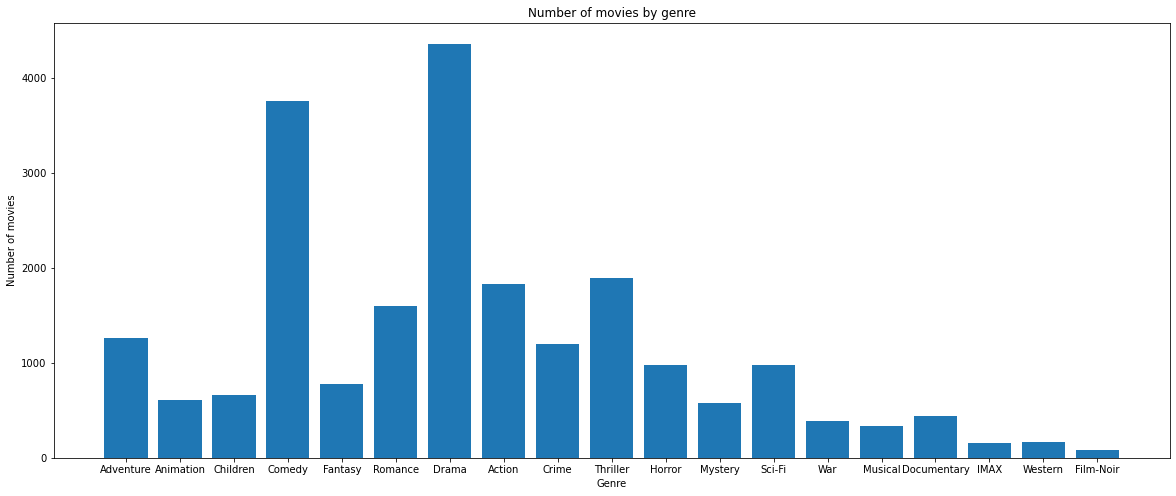

In [226]:
genre_names = list(genre_counts.keys())
genre_counts = list(genre_counts.values())
plt.figure(figsize=(20,8))
plt.bar(genre_names, genre_counts)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.title('Number of movies by genre')

# Show the plot
plt.show()

In [227]:
# Serepate the Genres Column and Encoding them with One-Hot Encoding
genres = []
for i in range(len(movies.genres)):
    for x in movies.genres[i].split('|'):
        if x not in genres:
            genres.append(x)
            
len(genres)
for x in genres:
    movies[x] = 0
for i in range(len(movies.genres)):
    for x in movies.genres[i].split('|'):
        movies[x][i]=1
        
#dropping the genres column as it's a no longer required
movies.drop(columns='genres', inplace=True)
movies.sort_index(inplace=True)
movies


<ipython-input-227-d1b834bcaca8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies[x][i]=1


,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story (1995),1995,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9694,193581,Black Butler: Book of the Atlantic (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9695,193583,No Game No Life: Zero (2017),2017,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9696,193585,Flint (2017),2017,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9697,193587,Bungo Stray Dogs: Dead Apple (2018),2018,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9699 entries, 0 to 9698
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movieId      9699 non-null   int64 
 1   title        9699 non-null   object
 2   year         9699 non-null   object
 3   Adventure    9699 non-null   int64 
 4   Animation    9699 non-null   int64 
 5   Children     9699 non-null   int64 
 6   Comedy       9699 non-null   int64 
 7   Fantasy      9699 non-null   int64 
 8   Romance      9699 non-null   int64 
 9   Drama        9699 non-null   int64 
 10  Action       9699 non-null   int64 
 11  Crime        9699 non-null   int64 
 12  Thriller     9699 non-null   int64 
 13  Horror       9699 non-null   int64 
 14  Mystery      9699 non-null   int64 
 15  Sci-Fi       9699 non-null   int64 
 16  War          9699 non-null   int64 
 17  Musical      9699 non-null   int64 
 18  Documentary  9699 non-null   int64 
 19  IMAX         9699 non-null 

In [229]:
#Finding out the average rating per movie and more importantly how many ratings they have...
avg_rating = ratings.groupby('movieId').rating.mean().rename('avg_rating')
num_rating = ratings.groupby('movieId').userId.count().rename('num_rating')
print(avg_rating.head())
print(num_rating.head())

movieId
1    3.920930
2    3.431818
3    3.259615
4    2.357143
5    3.071429
Name: avg_rating, dtype: float64
movieId
1    215
2    110
3     52
4      7
5     49
Name: num_rating, dtype: int64


In [230]:
# Finally time to merge tables, 
movies = pd.merge(movies, avg_rating, how='left', on='movieId')
movies = pd.merge(movies, num_rating, how='left', on='movieId')

movies['avg_rating'].fillna(0, inplace=True)
movies['num_rating'].fillna(0, inplace=True)

In [231]:
# Another merge to get userId in there....
movie_and_ratings = pd.merge(ratings, movies, how='left', on = 'movieId')


In [232]:
movie_and_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       100836 non-null  int64  
 1   movieId      100836 non-null  int64  
 2   rating       100836 non-null  float64
 3   title        100781 non-null  object 
 4   year         100781 non-null  object 
 5   Adventure    100781 non-null  float64
 6   Animation    100781 non-null  float64
 7   Children     100781 non-null  float64
 8   Comedy       100781 non-null  float64
 9   Fantasy      100781 non-null  float64
 10  Romance      100781 non-null  float64
 11  Drama        100781 non-null  float64
 12  Action       100781 non-null  float64
 13  Crime        100781 non-null  float64
 14  Thriller     100781 non-null  float64
 15  Horror       100781 non-null  float64
 16  Mystery      100781 non-null  float64
 17  Sci-Fi       100781 non-null  float64
 18  War          100781 non-

In [233]:
movie_and_ratings.head(3)

,userId,movieId,rating,title,year,Adventure,Animation,Children,Comedy,Fantasy,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,avg_rating,num_rating
0,1,1,4.0,Toy Story (1995),1995,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.920930,215.0
1,1,3,4.0,Grumpier Old Men (1995),1995,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.259615,52.0
2,1,6,4.0,Heat (1995),1995,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.946078,102.0


In [234]:
# sort by ratings counts 

movie_and_ratings_sorted = (
    movie_and_ratings
    .sort_values(by='num_rating', ascending=False)
    .drop_duplicates('movieId')
    )

movie_and_ratings_sorted

,userId,movieId,rating,title,year,Adventure,Animation,Children,Comedy,Fantasy,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,avg_rating,num_rating
76283,480,356,5.0,Forrest Gump (1994),1994,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.164134,329.0
3909,24,318,4.5,"Shawshank Redemption, The (1994)",1994,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.429022,317.0
18412,117,296,4.0,Pulp Fiction (1994),1994,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.197068,307.0
50481,326,593,4.5,"Silence of the Lambs, The (1991)",1991,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.161290,279.0
23520,160,2571,4.0,"Matrix, The (1999)",1999,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.192446,278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88136,567,156605,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92128,596,141131,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92154,596,181719,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95014,599,132084,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
# Try to get rid of the Nan...
movie_and_ratings_sorted['avg_rating'].fillna(0, inplace=True)
movie_and_ratings_sorted['num_rating'].fillna(0, inplace=True)
movie_and_ratings_sorted

,userId,movieId,rating,title,year,Adventure,Animation,Children,Comedy,Fantasy,...,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,avg_rating,num_rating
76283,480,356,5.0,Forrest Gump (1994),1994,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.164134,329.0
3909,24,318,4.5,"Shawshank Redemption, The (1994)",1994,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.429022,317.0
18412,117,296,4.0,Pulp Fiction (1994),1994,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.197068,307.0
50481,326,593,4.5,"Silence of the Lambs, The (1991)",1991,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.161290,279.0
23520,160,2571,4.0,"Matrix, The (1999)",1999,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.192446,278.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88136,567,156605,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
92128,596,141131,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
92154,596,181719,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
95014,599,132084,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0


In [237]:
# merging ratings and movies data
matrix_df = pd.merge(ratings, movies, how='left', on = 'movieId')
# creating matrix
movie_user_matrix = matrix_df.pivot_table(index='userId', columns='title', values='avg_rating')
movie_user_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.134615,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.863636,2.770833,NaN,NaN,NaN


In [238]:
movie_user_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610 entries, 1 to 610
Columns: 9681 entries, '71 (2014) to À nous la liberté (Freedom for Us) (1931)
dtypes: float64(9681)
memory usage: 45.1 MB


This last table represents our user-item matrix. This is used in our recommendation system to represent the interactions between users and items, where each row is a userId and each column is an item, which in our case is a movie. 

The reason there are som many Nan's is becasue obviously not every user has seen much less rated every movie.

# Split the data into training and testing sets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Cold Start Engine:
cold_eng = movies[['movieId', 'title', 'year', 'avg_rating']]
X = cold_eng[['year', 'movieId']]
y = cold_eng['avg_rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model=RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean absolute error: {mae:.2f}')


##
# Use the model to make recommendations for a new user or movie
# For example, to make recommendations for a new user who likes action movies from the 1990s:
# new_user_data =

In [243]:
# First Models...

# instantiate a reader

reader = Reader(rating_scale=(0,5))

# load data

movies_df = Dataset.load_from_df(
    movie_and_ratings_sorted[['userId', 'title', 'rating']], 
    reader)

In [244]:
# create train and test datasets

train, test = train_test_split(movies, test_size=.2)

In [245]:
train

In [246]:
test

[(448, 'Deadfall (2012)', 1.5),
 (448, 'Death at a Funeral (2010)', 2.5),
 (39, 'Best in Show (2000)', 5.0),
 (313, 'Care Bears Movie, The (1985)', 1.0),
 (610, 'Crimson Peak (2015)', 3.5),
 (502, 'Inherit the Wind (1960)', 5.0),
 (448, 'Top Five (2014)', 3.0),
 (380, 'Dragon Ball Z: Battle of Gods (2013)', 4.0),
 (249, 'Lockout (2012)', 3.0),
 (599, 'Get Carter (1971)', 3.5),
 (274, 'Texas Chainsaw Massacre, The (2003)', 2.0),
 (567, 'Two Days, One Night (Deux jours, une nuit) (2014)', 3.5),
 (448, 'Welcome to the Jungle (2013)', 1.5),
 (603, 'Daughters of the Dust (1991)', 4.0),
 (474, 'Little Women (1933)', 3.5),
 (603, 'Walk on the Moon, A (1999)', 3.0),
 (89, 'Generation P (2011)', 3.5),
 (221, 'Network (1976)', 4.5),
 (448, 'Horrors of Spider Island (Ein Toter Hing im Netz) (1960)', 0.5),
 (599, 'Renaissance (2006)', 2.5),
 (606, 'Night Listener, The (2006)', 3.0),
 (64, 'Clockers (1995)', 3.5),
 (249, 'Jason X (2002)', 1.0),
 (318, 'My Scientology Movie (2016)', 3.5),
 (89, 'A P

In [247]:
dataset = movies_df.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  498 

Number of items:  9682


***
### SVD

Singular value decomposition (SVD) is a matrix factorization technique that can be used to decompose a matrix into its constituent parts. In the context of recommendation systems, SVD can be used to decompose a user-item matrix into the product of three matrices: a user matrix, a diagonal matrix of singular values, and an item matrix. These matrices can then be used to make recommendations to users.

***

In [251]:
svd = SVD()

# fit data on train set
svd.fit(train)

# predict/test on test aset
svd_predictions = svd.test(test)

# check RMSE and MAE
accuracy.rmse(svd_predictions)
accuracy.mae(svd_predictions)

RMSE: 0.9477
MAE:  0.7496


0.7496288791765796

In [257]:
# From lesson *
# Perform a gridsearch with SVD
# ⏰ This cell may take several minutes to run
params = {'n_factors': [20, 50, 100],
          'n_epochs':[5,10],
          'lr_all':[0.002, 0.005],
         'reg_all': [0.02, 0.1, 0.5]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(movies_df)

# n_factors = latent/underlying factors-higher can improve but also overfit
# n_epochs = iterations, higher can learn more but also overfit

In [258]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.9444867867090657, 'mae': 0.7451819166617334}
{'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.02}}


In [260]:
# FINAL SVD MODEL

#best_estimator attribute will contain best parameters from the GridSearch ran previously...

svd_algo = g_s_svd.best_estimator['rmse']
svd_algo.fit(movies_df.build_full_trainset())

svd_best_predictions = svd_algo.test(test)

# check RMSE and MAE of final SVD model 

accuracy.rmse(svd_best_predictions)
accuracy.mae(svd_best_predictions)

RMSE: 0.8723
MAE:  0.6910


0.6909942391928379

#### Final SVD Model:
Final RMSE is a respectable 0.87, which we can look at as the average predicted rating being .87 stars away from the actual rating.


#### RMSE
The root mean squared error (RMSE) is a measure of the accuracy of a prediction model. 

In a recommendation system, the RMSE score is calculated by taking the square root of the mean squared error between the predicted ratings and the actual ratings in the test set. The mean squared error is calculated by taking the sum of the squared differences between the predicted and actual ratings, and dividing by the number of ratings in the test set.

A lower RMSE score indicates that the model is making more accurate predictions, while a higher RMSE score indicates that the model is making less accurate predictions.

#### MAE

In a recommendation system, the MAE is calculated by taking the absolute value of the difference between the predicted ratings and the actual ratings in the test set, and averaging these differences over the number of ratings in the test set.

Like the root mean squared error (RMSE), the MAE is a measure of the average error of the model's predictions. However, unlike the RMSE, the MAE does not square the errors before averaging them, which means that it is less sensitive to large errors and may be more appropriate for data with a large number of outliers. And again,the lower the score the better.

***
### KNN
In addition to using SVD, we will also run and compare some KNN algo's.  In a recommendation system, KNN works by finding the K nearest neighbors of a user or item, and using these neighbors to make recommendations.

***

In [254]:
cv_knn_basic = cross_validate(KNNBasic(), movies_df, cv=5, n_jobs=5, verbose=True)
cv_knn_means = cross_validate(KNNWithMeans(), movies_df, cv=5, n_jobs=5, verbose=True)
cv_knn_z = cross_validate(KNNWithZScore(), movies_df, cv=5, n_jobs=5, verbose=True)



Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0814  1.1197  1.0838  1.0707  1.0848  1.0881  0.0166  
MAE (testset)     0.8842  0.9135  0.8743  0.8683  0.8843  0.8849  0.0155  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0867  1.0817  1.0755  1.0907  1.1062  1.0882  0.0104  
MAE (testset)     0.8843  0.8802  0.8720  0.8843  0.9035  0.8849  0.0103  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  

In [269]:
# Printing out the results for the KNN algorithms
print('Evaluation Results:')
print('Algoritm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(cv_knn_basic['test_rmse'].mean(), 4), '\t\t', round(cv_knn_basic['test_mae'].mean(), 4))
print('KNN Means', '\t', round(cv_knn_means['test_rmse'].mean(), 4), '\t', round(cv_knn_means['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(cv_knn_z['test_rmse'].mean(), 4), '\t', round(cv_knn_z['test_mae'].mean(), 4))
print()


Evaluation Results:
Algoritm	 RMSE		 MAE

KNN Basic 	 1.0882 		 0.885
KNN Means 	 1.0882 	 0.8849
KNN ZScore 	 1.0882 	 0.885



In [275]:

param_grid = {'k': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
              'sim_options': {'user_based': [True, False]},\
              'bsl_options': {'method': ['als', 'sgd']}}

gs_knnb = GridSearchCV(KNNBaseline, 
                       param_grid, 
                       measures=['rmse', 'mae'], 
                       cv=5)

gs_knnb.fit(movies)

print(gs_knnb.best_score['rmse'])
print(gs_knnb.best_params['rmse'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
Computing the msd similarity matr

In [276]:
# FINAL KNN MODEL

knnb_algo = gs_knnb.best_estimator['rmse']
knnb_algo.fit(movies.build_full_trainset())

knnb_best_predictions = knnb_algo.test(test)

# check RMSE and MAE of final KNN model 

accuracy.rmse(knnb_best_predictions)
accuracy.mae(knnb_best_predictions)

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.0407
MAE:  0.0022


0.002171837468133892

#### Final KNN Algo
After running the GridSearch on our KNN Baseline algo we can see a few things. First it is what we call computationally expensive, meaning it takes quite some time to run in order to calculate the distance between every user and item in the dataset. And while we also see that we have reduced our error scores by a large margin we will not be using the KNN models moving forward. The reason for running these algorithms is becuase it is just good practice to try different models and algorithms to find the one that best fits our specific needs. And with a dataset like this, KNN is too expensive and Im also concerned with overfitting with these parameters. 

In [ ]:
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [ ]:
user_rating = movie_rater(movies, 4, 'Comedy')

In [ ]:
user_rating

In [ ]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = new_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [ ]:
# order the predictions from highest to lowest rated
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [ ]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

In [ ]:
print(recommended_movies(ranked_movies,movies,5))

In [ ]:
import pandas as pd

# Load the Movielens dataset


# Join the movies and ratings dataframes on the movieId column
movies_with_ratings = pd.merge(movies, ratings, on='movieId')

# Create a pivot table with users as rows, movies as columns, and ratings as values
user_movie_ratings = pd.pivot_table(movies_with_ratings,
                                    index='userId',
                                    columns='title',
                                    values='rating')



In [ ]:
# Use the pivot table to create a similarity matrix
user_similarity = user_movie_ratings.corr(method='kendall')




In [ ]:

# Use the similarity matrix to make recommendations for a new user
new_user_rating = pd.Series([3.5, 5.0, 4.0, 5.0, 3.0],
                            index=['Pulp Fiction', 'Back to the Future',
                                   'The Shawshank Redemption', 'The Godfather',
                                   'The Silence of the Lambs'])





In [ ]:


# Calculate the dot product of the new user's ratings with the similarity matrix
recommendations = user_similarity.dot(new_user_rating)




In [ ]:
# 